<a href="https://colab.research.google.com/github/DJCordhose/transformers/blob/main/notebooks/Bunny_Llama_3_8B_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bunny: lightweight but powerful multimodal models

https://huggingface.co/BAAI/Bunny-Llama-3-8B-V

Bunny-Llama-3-8B-V is built upon https://huggingface.co/google/siglip-so400m-patch14-384 (CLIP, a multimodal model, with a better loss function) and https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct.

## GPU >= L4 having 24GB having full resolution

Does not run on a T4, even though Llama-3-8B would do with 16GB as we have the additional SigLIP. Works on the L4 having 24GB, though.

### T4 works if reduced to 8 oder 4 Bits


## watch nvidia-smi

You might want to run `watch nvidia-smi` in a Terminal below this notebook to see how

memory
utilization (shown as percentage) and
temperature
develop when executing this.

In [1]:
!nvidia-smi

Mon May  6 15:17:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -qU pillow

In [3]:
!pip install -qU transformers

In [4]:
!pip install -qU accelerate bitsandbytes

In [5]:
!wget https://huggingface.co/BAAI/Bunny-Llama-3-8B-V/resolve/main/images/example_2.png?download=true -O example_2.png

--2024-05-06 15:18:15--  https://huggingface.co/BAAI/Bunny-Llama-3-8B-V/resolve/main/images/example_2.png?download=true
Resolving huggingface.co (huggingface.co)... 13.35.7.38, 13.35.7.57, 13.35.7.5, ...
Connecting to huggingface.co (huggingface.co)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74589 (73K) [image/png]
Saving to: ‘example_2.png’

example_2.png       100%[===================>]  72.84K   366KB/s    in 0.2s    

2024-05-06 15:18:16 (366 KB/s) - ‘example_2.png’ saved [74589/74589]



In [6]:
!wget https://huggingface.co/BAAI/Bunny-Llama-3-8B-V/resolve/main/images/example_1.png?download=true -O example_1.png

--2024-05-06 15:18:16--  https://huggingface.co/BAAI/Bunny-Llama-3-8B-V/resolve/main/images/example_1.png?download=true
Resolving huggingface.co (huggingface.co)... 13.35.7.38, 13.35.7.57, 13.35.7.5, ...
Connecting to huggingface.co (huggingface.co)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244967 (239K) [image/png]
Saving to: ‘example_1.png’

example_1.png       100%[===================>] 239.23K   597KB/s    in 0.4s    

2024-05-06 15:18:16 (597 KB/s) - ‘example_1.png’ saved [244967/244967]



In [7]:
!ls -lh *.png

-rw-r--r-- 1 root root 240K May  6 15:18 example_1.png
-rw-r--r-- 1 root root  73K May  6 15:18 example_2.png


In [8]:
from PIL import Image

In [9]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import warnings

warnings.filterwarnings('ignore')
model_id = "BAAI/Bunny-Llama-3-8B-V"

# set device
device = 'cuda'  # or cpu
torch.set_default_device(device)

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
compute_dtype = getattr(torch, "float16")
from transformers import BitsAndBytesConfig

bnb4_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
)
bnb8_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_quant_type="nf4",
        bnb_8bit_compute_dtype=compute_dtype,
        bnb_8bit_use_double_quant=True,
)

Unused kwargs: ['bnb_8bit_quant_type', 'bnb_8bit_compute_dtype', 'bnb_8bit_use_double_quant']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [11]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # torch_dtype=torch.float16, # for full resolution
    # torch_dtype=torch.float32, # for cpu
    quantization_config=bnb4_config,  # for 4 bit resolution
    # quantization_config=bnb8_config,  # for 8 bit resolution
    # device_map='auto',
    trust_remote_code=True)


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at BAAI/Bunny-Llama-3-8B-V were not used when initializing BunnyLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.26.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.mlp.fc2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.self_attn.k_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.26.self_attn.k_proj.weight', 'model.vision_tower.vision_tower.vision_model.

# Image 2

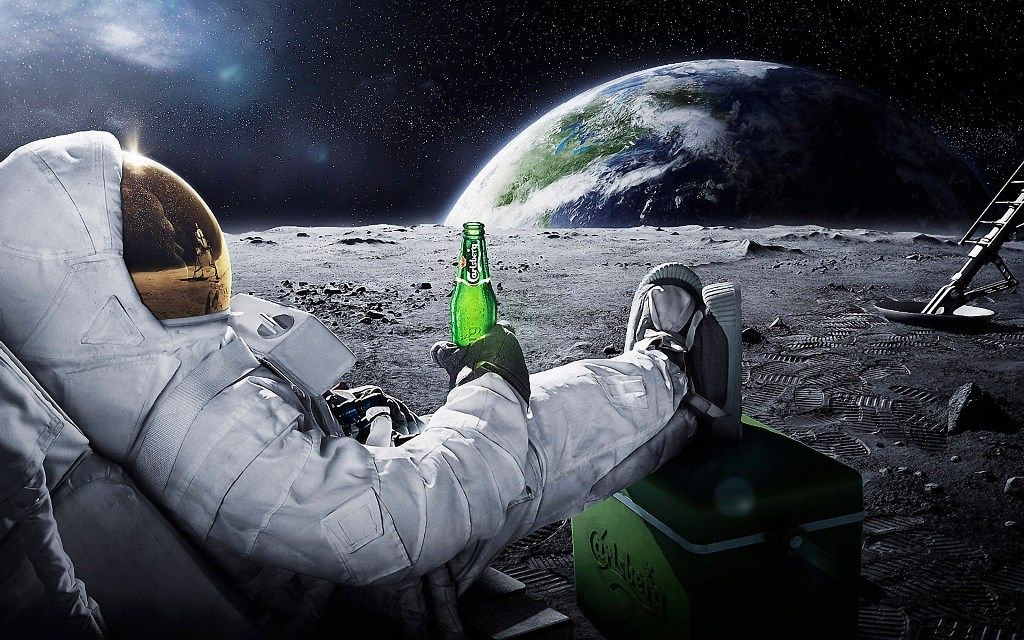

In [12]:
image1 = Image.open('example_1.png')
image1

In [13]:
image = image1

# text prompt
prompt = 'Why is the image funny?'
text = f"A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <image>\n{prompt} ASSISTANT:"
text_chunks = [tokenizer(chunk).input_ids for chunk in text.split('<image>')]
input_ids = torch.tensor(text_chunks[0] + [-200] + text_chunks[1][1:], dtype=torch.long).unsqueeze(0).to(device)

image_tensor = model.process_images([image], model.config).to(dtype=model.dtype, device=device)

# generate
output_ids = model.generate(
    input_ids,
    images=image_tensor,
    max_new_tokens=100,
    use_cache=True)[0]

print(tokenizer.decode(output_ids[input_ids.shape[1]:], skip_special_tokens=True).strip())

The image is funny because it depicts a man in a space suit, which is an unusual and unexpected setting. The man is sitting on the ground, holding a beer, and wearing a pair of sneakers, which is not typical attire for someone in a space suit. The combination of these elements creates a humorous and surreal scene.


## Responses

### response full resolution
> The image is funny because it depicts a surreal scene of an astronaut sitting on the moon, relaxing with a beer. It's an unexpected and humorous juxtaposition of a typical leisure activity with the extraordinary environment of space.

### response 8 bit
>The image is funny because it depicts a surreal scene of an astronaut sitting on the moon, relaxing with a beer. It's an unexpected and humorous juxtaposition of a typical leisure activity with the extraordinary environment of space.

### response 4 bit

> The image is funny because it depicts a man in a space suit, which is an unusual and unexpected setting. The man is sitting on the ground, holding a beer, and wearing a pair of sneakers, which is not typical attire for someone in a space suit. The combination of these elements creates a humorous and surreal scene.

# Example 2

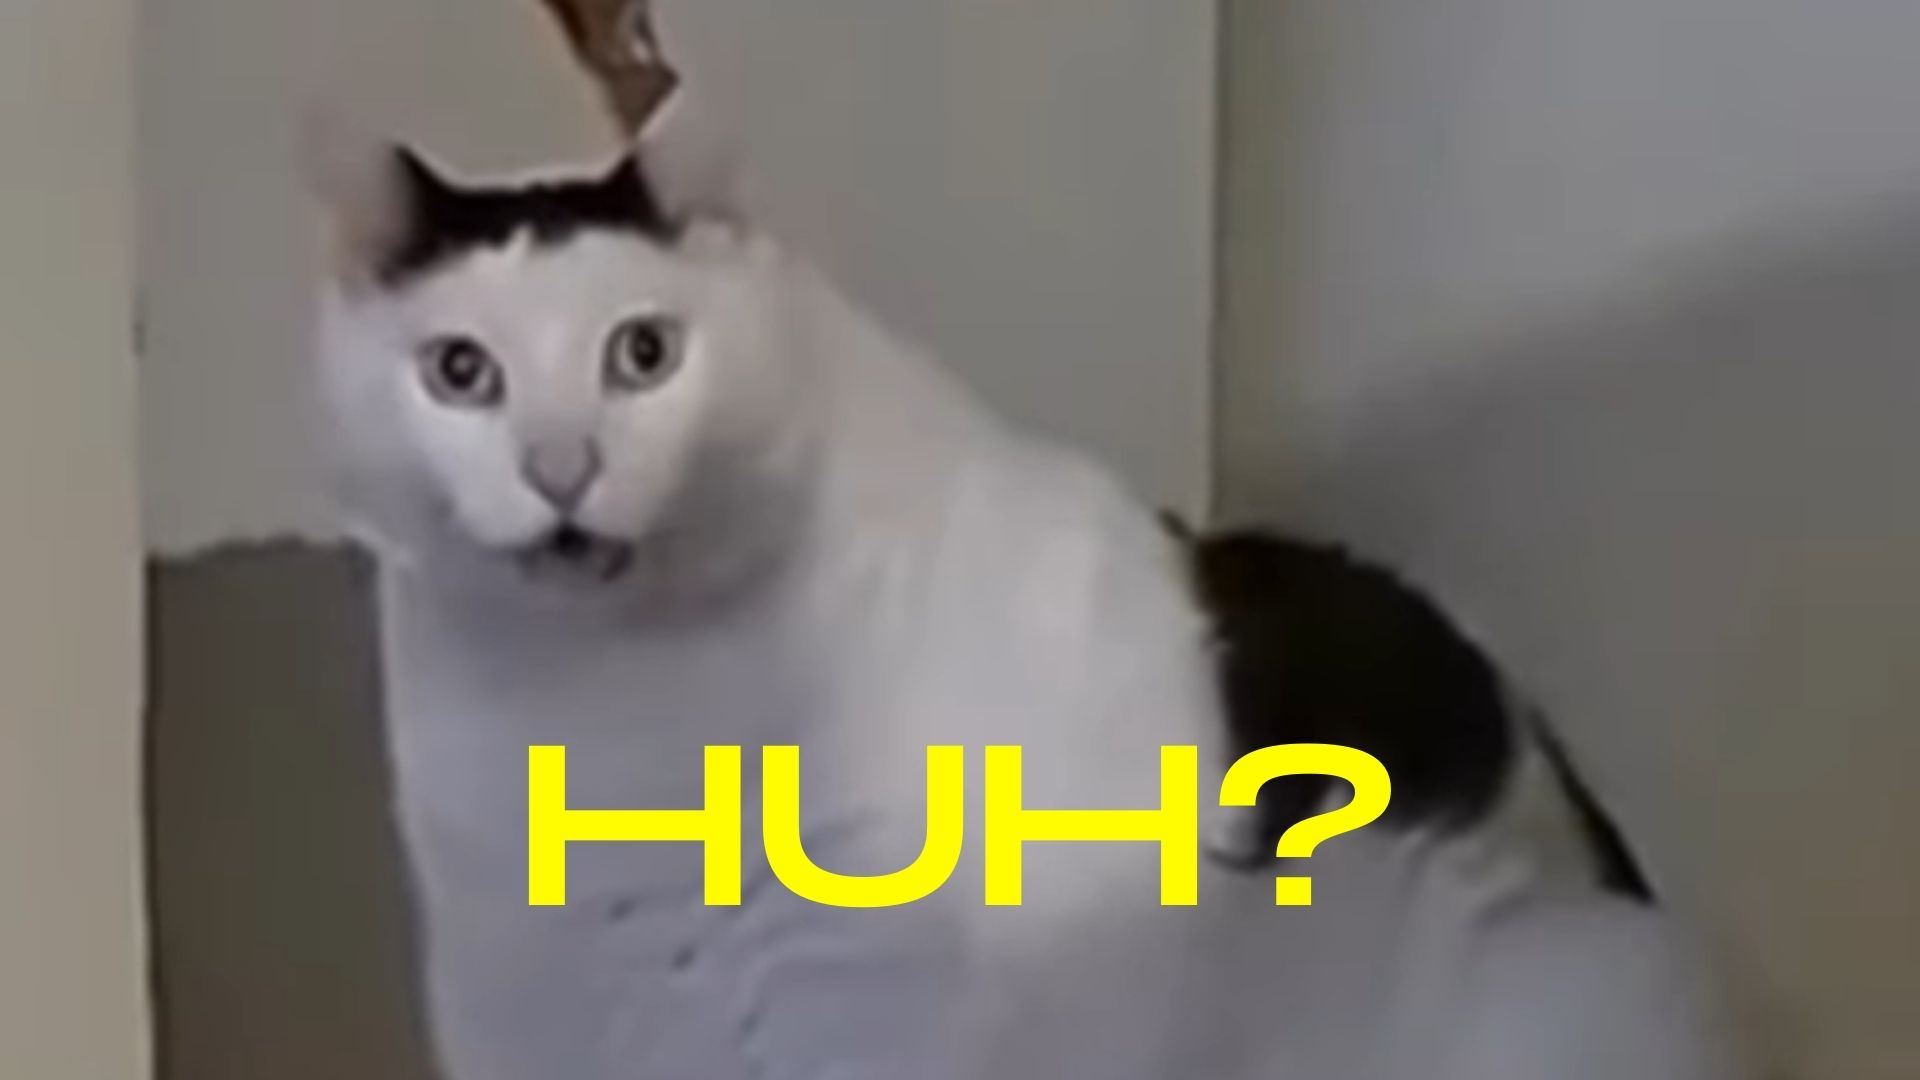

In [14]:
image2 = Image.open('example_2.png')
image2

In [15]:
image = image2

# text prompt
prompt = 'Why is the image funny?'
text = f"A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <image>\n{prompt} ASSISTANT:"
text_chunks = [tokenizer(chunk).input_ids for chunk in text.split('<image>')]
input_ids = torch.tensor(text_chunks[0] + [-200] + text_chunks[1][1:], dtype=torch.long).unsqueeze(0).to(device)

image_tensor = model.process_images([image], model.config).to(dtype=model.dtype, device=device)

# generate
output_ids = model.generate(
    input_ids,
    images=image_tensor,
    max_new_tokens=100,
    use_cache=True)[0]

print(tokenizer.decode(output_ids[input_ids.shape[1]:], skip_special_tokens=True).strip())

The image is funny because it features a cat with a surprised expression, as if it's asking a question. The yellow text "Huh?" is placed on the cat, making it appear as if the cat is asking a question.


## Responses

### response full resolution
> The image is funny because it features a cat with a surprised expression, as if it's asking a question. The yellow text "Huh?" is placed on the cat, which adds to the comedic effect.

### response 8 bit
> The image is funny because it features a cat with a surprised expression, as if it's asking a question. The cat's mouth is open, and it's looking directly at the camera, which adds to the comedic effect.

### response 4 bit
> The image is funny because it features a cat with a surprised expression, as if it's asking a question. The yellow text "Huh?" is placed on the cat, making it appear as if the cat is asking a question.


# Memory consumption for model

In [16]:
!nvidia-smi

Mon May  6 15:19:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              57W /  70W |   6817MiB / 15360MiB |     40%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--